# MAAP complementation analysis 

Here we analyze the data supporting discovery of the new gene MAAP.  
Analysis includes  
- constructuing a frameshift lookup table for detemrining effects 
- global look at MAAPs affect across gene, with or without trans complementation 
- bootstrap method for constrcuting p-values signfying stop codon importance in frame 2 
- valiation data for individual mutants

In [1]:
import os
import sys 

import pandas as pd 
pd_idx =pd.IndexSlice
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import scipy.stats as stats
import scipy.special as special

import common 

sys.path.append('../x01_process_data/')
import x02_load_dataframes
import x03_compute_selections

sys.path.append('../settings/')
from paths_new import FIGURES_DIR
from paths_new import META_DIR
from paths_new import DESIRED_AA_ORD
from paths_new import LOOKUP_DF
from paths_new import DATA_DIR
from paper_settings import PAPER_PRESET
from paper_settings import PAPER_FONTSIZE
from paper_settings import save_fig
sns.set(**PAPER_PRESET)

%reload_ext autoreload
%autoreload 2

### load in data, need packaging data from MAAP experiments as well as original packaging data 

In [2]:
maap_counts = x02_load_dataframes.load_MAAP_df()
package_counts = x02_load_dataframes.load_packaging_df()

### pEL plasmid labels describe the complement experiment which was run during packaging 
- pRep: only inlcude the pRep plasmid to facilitate normal packaging in library 
- pEK_254: include a plasmid which contains pRep as well as the downstream wildtype MAAP region 
- pEK_256: include a plasmid which contains the downstream MAAP region, but with a stop codon substitution 
- pEK_258: same as above, but with a mutation to MAAP start codon   
we also ran bioligically packaging experiment replicates as well 

In [3]:
maap_counts.head()

name                                                                                               pEK_254  \
complement                                                                                            True   
mutation                                                                                                WT   
replicate                                                                                                1   
abs_pos tile_num aa is_wt_aa is_wt_codon wt_bc lib_type enzyme codon aa-codon barcode                        
1.0     0.0      *  0        0           0     sub      bbsi   TAA   *-TAA    CACTGTCACACACTGACACT  2056.0   
                                                                              CTGTGAGTGTGAGAGACACT   891.0   
                                                               TAG   *-TAG    CTCTCACACAGTGAGTCTGA     1.0   
                                                                              CAGAGACAGAGTCTGTCACT   612.0   
                                                               TGA   *-TGA    ACACTGTCTCTGTCAGACAG  3019.0   

name                                                                                                        \
complement                                                                                                   
mutation                                                                                                     
replicate                                                                                                2   
abs_pos tile_num aa is_wt_aa is_wt_codon wt_bc lib_type enzyme codon aa-codon barcode                        
1.0     0.0      *  0        0           0     sub      bbsi   TAA   *-TAA    CACTGTCACACACTGACACT   168.0   
                                                                              CTGTGAGTGTGAGAGACACT   379.0   
                                                               TAG   *-TAG    CTCTCACACAGTGAGTCTGA     1.0   
                                                                              CAGAGACAGAGTCTGTCACT     NaN   
                                                               TGA   *-TGA    ACACTGTCTCTGTCAGACAG  1548.0   

name                                                                                               pEK_256  \
complement                                                                                           False   
mutation                                                                                           P32_ATA   
replicate                                                                                                1   
abs_pos tile_num aa is_wt_aa is_wt_codon wt_bc lib_type enzyme codon aa-codon barcode                        
1.0     0.0      *  0        0           0     sub      bbsi   TAA   *-TAA    CACTGTCACACACTGACACT     1.0   
                                                                              CTGTGAGTGTGAGAGACACT     4.0   
                                                               TAG   *-TAG    CTCTCACACAGTGAGTCTGA     NaN   
                                                                              CAGAGACAGAGTCTGTCACT     2.0   
                                                               TGA   *-TGA    ACACTGTCTCTGTCAGACAG     6.0   

name                                                                                                       \
complement                                                                                                  
mutation                                                                                                    
replicate                                                                                               2   
abs_pos tile_num aa is_wt_aa is_wt_codon wt_bc lib_type enzyme codon aa-codon barcode                       
1.0     0.0      *  0        0           0     sub      bbsi   TAA   *-TAA    CACTGTCACACACTGACACT  587.0   
                                           

### compute selection from the counts

In [4]:
maap_selection = x03_compute_selections.compute_maap_selection(package_counts, maap_counts)

In [5]:
maap_selection.head()

name                                                   pEK_254            \
complement                                                True             
mutation                                                    WT             
replicate                                                    1         2   
abs_pos aa is_wt_aa is_wt_codon wt_bc lib_type codon                       
1.0     *  0        0           0     sub      TAA    0.206078  0.182197   
                                               TAG    0.241915  0.001880   
                                               TGA    0.283103  0.495479   
        -  0        0           0     del      ---    0.625505  0.595888   
        A  0        0           0     sub      GCA    0.038809  0.312080   

name                                                   pEK_256            \
complement                                               False             
mutation                                               P32_ATA             
replicate                                                    1         2   
abs_pos aa is_wt_aa is_wt_codon wt_bc lib_type codon                       
1.0     *  0        0           0     sub      TAA    0.563051  0.350269   
                                               TAG    1.271040  0.304231   
                                               TGA    0.634519  0.154619   
        -  0        0           0     del      ---         NaN  0.712621   
        A  0        0           0     sub      GCA         NaN  0.087560   

name                                                   pEK_258            \
complement                                               False             
mutation                                               P27_CCC             
replicate                                                    1         2   
abs_pos aa is_wt_aa is_wt_codon wt_bc lib_type codon                       
1.0     *  0        0           0     sub      TAA    1.010522  0.350306   
                                               TAG         NaN  0.316218   
                                               TGA    0.203355  0.132152   
        -  0        0           0     del      ---         NaN  0.191300   
        A  0        0           0     sub      GCA         NaN  0.279270   

name                                                      pRep            
complement                                               False            
mutation                                                    WT            
replicate                                                    1         2  
abs_pos aa is_wt_aa is_wt_codon wt_bc lib_type codon                      
1.0     *  0        0           0     sub      TAA    0.972166  0.431626  
                                               TAG         NaN  0.252974  
                                               TGA    0.304323  0.361889  
        -  0        0           0     del      ---         NaN  0.323358  
        A  0        0           0     sub      GCA         NaN  0.249009

### constrcut a table which informs what mutations were made in frame 2 
since the library contains all single mutations in frame 1, we need to convert these to the possible mutations made in frame 2 

In [6]:
frameshift_meta_lookup_df = common.make_all_frame_lookup(LOOKUP_DF)

merge this new table with the selection data, and construct a few more useful columns for analysis

In [7]:
maap_selection_and_lookup = frameshift_meta_lookup_df.merge(maap_selection.reset_index(), on=[ 'abs_pos','aa', 'codon'], how='inner')

# add easy stop identifier 
stop_obj = []
for idx, row in maap_selection_and_lookup.iterrows():
    if row['maap_aa_swap_first'] =='*' or row['maap_aa_swap_second'] =='*':
        x =1 
    else: 
        x=0
    stop_obj.append(x)
maap_selection_and_lookup['stop_maap'] = stop_obj

## set up useful indeces
maap_selection_and_lookup = maap_selection_and_lookup.set_index(list(maap_selection_and_lookup.columns[:31]))
maap_selection_and_lookup.set_index('stop_maap',append=True,inplace=True)
maap_selection_and_lookup.index = maap_selection_and_lookup.index.droplevel([-5,-4,-3,-2])
maap_selection_and_lookup.columns = pd.MultiIndex.from_tuples(maap_selection_and_lookup.columns)
maap_selection_and_lookup.drop_duplicates(inplace=True)

#an example with a stop codon
maap_selection_and_lookup.xs((50,'L'), level=['abs_pos', 'aa'],drop_level=False)

/home/ubuntu/repos/AAV_fitness_landscape/venv/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 4 on the right)
  warnings.warn(msg, UserWarning)
/home/ubuntu/repos/AAV_fitness_landscape/venv/lib/python3.6/site-packages/pandas/core/generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


pEK_254  \
                                                                                                                                                                                                                                                                                                                                                                                                                                                                  True   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                    WT   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                     1   
aa abs_pos barcode              codon enzyme is_wt_aa is_wt_codon lib_type tile_num wt_bc aa-codon frame3_aa_swap_first frame3_aa_swap_second frame3_codon_swap_first frame3_codon_swap_second frame3_wt_aa_first frame3_wt_aa_second frame3_wt_codon_first frame3_wt_codon_second maap_aa_swap_first maap_aa_swap_second maap_codon_swap_first maap_codon_swap_second maap_wt_aa_first maap_wt_aa_second maap_wt_codon_first maap_wt_codon_second stop_maap             
L  50.0    GACACACAGACAGAGTCACA CTA   bbsi   0        0           sub      1.0      0     L-CTA    A                    K                     GCT                     AAA                      V                  Q                   GTA                   CAA                    G                  *                   GGC                   TAA                    G                T                 GGT                 ACA                  1          0.415540   
           GAGTGAGTCACACTGTGACT CTC   bbsi   0        0           sub      1.0      0     L-CTC    A                    Q                     GCT                     CAA                      V                  Q                   GTA                   CAA                    G                  S                   GGC                   TCA                    G                T                 GGT                 ACA                  0          0.001313   
           GAGTCTCTGACTGTGAGAGT CTG   bbsi   0        0           sub      1.0      0     L-CTG    A                    E                     GCT                     GAA                      V                  Q                   GTA                   CAA                    G                  *                   GGC                   TGA                    G                T                 GGT                 ACA                  1          0.015050   
           ACTCTCTGACTGTGACACTG CTT   bbsi   0        0           sub      1.0      0     L-CTT    A                    *                     GCT                     TAA                      V                  Q                   GTA                   CAA                    G                  L                   GGC                   TTA                    G                T                 GGT                 ACA                  0          0.001326   
           TCACTCTCACTCACACTCAC TTA   bbsi   0        0           sub      1.0      0     L-TTA    V                    K                     GTT                     AAA                      V                  Q                   GTA                   CAA                    G                  *                   GGT        

### from this, we take only the positions which contain at least one stop codon in frame 2 

In [8]:
aa_pos_with_stops = maap_selection_and_lookup.xs(1, level='stop_maap',drop_level=False)


In [9]:
aa_pos_with_stops.head()

pEK_254  \
                                                                                                                                                                                                                                                                                                                                                                                                                                                                  True   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                    WT   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                     1   
aa abs_pos barcode              codon enzyme is_wt_aa is_wt_codon lib_type tile_num wt_bc aa-codon frame3_aa_swap_first frame3_aa_swap_second frame3_codon_swap_first frame3_codon_swap_second frame3_wt_aa_first frame3_wt_aa_second frame3_wt_codon_first frame3_wt_codon_second maap_aa_swap_first maap_aa_swap_second maap_codon_swap_first maap_codon_swap_second maap_wt_aa_first maap_wt_aa_second maap_wt_codon_first maap_wt_codon_second stop_maap             
I  2.0     ACTGAGTGTGAGACTCAGTC ATA   bbsi   0        0           sub      0.0      0     I-ATA    D                    S                     GAT                     AGC                      G                  C                   GGC                   TGC                    *                  *                   TGA                   TAG                    W                L                 TGG                 CTG                  1          0.141234   
           CTCTCAGACACAGTGTCAGA ATC   bbsi   0        0           sub      0.0      0     I-ATC    D                    R                     GAT                     CGC                      G                  C                   GGC                   TGC                    *                  S                   TGA                   TCG                    W                L                 TGG                 CTG                  1          0.316915   
           GAGTGTCTCACAGAGTGTGA ATT   bbsi   0        0           sub      0.0      0     I-ATT    D                    C                     GAT                     TGC                      G                  C                   GGC                   TGC                    *                  L                   TGA                   TTG                    W                L                 TGG                 CTG                  1          0.251578   
K  2.0     GACTGACTCTCAGTGAGAGT AAA   bbsi   0        0           sub      0.0      0     K-AAA    E                    S                     GAA                     AGC                      G                  C                   GGC                   TGC                    *                  K                   TGA                   AAG                    W                L                 TGG                 CTG                  1          0.239661   
           CACAGAGTCAGTGTCTGACA AAG   bbsi   0        0           sub      0.0      0     K-AAG    E                    G                     GAA                     GGC                      G                  C                   GGC                   TGC                    *                  R                   TGA        

reshape the dataframe for plotting  

In [10]:
aa_pos_with_stops_index = aa_pos_with_stops.reset_index(
        )[['aa','abs_pos']]

maap_idx_names = maap_selection_and_lookup.index.names
maap_aa_has_stop = aa_pos_with_stops_index.merge(maap_selection_and_lookup.reset_index(),on=['aa','abs_pos'],how='left').set_index(maap_idx_names)
maap_aa_has_stop_subset = pd.concat([maap_aa_has_stop.xs(['pEK_254','1'], level=[0,3],axis=1,drop_level=False),
                                     maap_aa_has_stop.xs(['pRep','2'], level=[0,3],axis=1,drop_level=False),
                                     maap_aa_has_stop.xs(['pEK_256','2'], level=[0,3],axis=1,drop_level=False),
                                     maap_aa_has_stop.xs(['pEK_258','2'], level=[0,3],axis=1,drop_level=False)],axis=1)
new_idx = maap_aa_has_stop_subset.reset_index(
    )[['abs_pos', 'aa', 'codon', 'stop_maap']].set_index(['abs_pos', 'aa', 'codon', 'stop_maap'])
maap_aa_has_stop_subset.index = new_idx.index
maap_aa_has_stop_subset.head()

pEK_254      pRep   pEK_256   pEK_258
                                True     False     False     False
                                  WT        WT   P32_ATA   P27_CCC
                                   1         2         2         2
abs_pos aa codon stop_maap                                        
2.0     I  ATA   1          0.141234  0.500119  0.340017  0.290785
           ATC   1          0.316915  0.553599  0.215455  0.231352
           ATT   1          0.251578  0.453041  0.389071  0.395181
           ATA   1          0.141234  0.500119  0.340017  0.290785
           ATC   1          0.316915  0.553599  0.215455  0.231352

In [11]:
maap_aa_has_stop_subset_copy = maap_aa_has_stop_subset.copy()
maap_aa_has_stop_subset_copy.columns = maap_aa_has_stop_subset_copy.columns.droplevel([1,2,3])
maap_aa_has_stop_subset_copy.head()

pEK_254      pRep   pEK_256   pEK_258
abs_pos aa codon stop_maap                                        
2.0     I  ATA   1          0.141234  0.500119  0.340017  0.290785
           ATC   1          0.316915  0.553599  0.215455  0.231352
           ATT   1          0.251578  0.453041  0.389071  0.395181
           ATA   1          0.141234  0.500119  0.340017  0.290785
           ATC   1          0.316915  0.553599  0.215455  0.231352

for each position compute the mean selection value for stop and non stop mutations

In [12]:
maap_pos_mean_stop_unstack = maap_aa_has_stop_subset_copy.groupby(
    level=['abs_pos', 'aa', 'stop_maap']).mean().unstack(-1).dropna()


##  known position which makes stops 
maap_pos_mean_stop_unstack.query("abs_pos==53")

pEK_254                pRep             pEK_256            \
stop_maap          0         1         0         1         0         1   
abs_pos aa                                                               
53.0    I   0.819709  0.185429  0.390238  0.400504  0.228357  0.278135   
        L   0.450129  0.859870  0.890274  0.240772  0.509995  0.158629   
        V   0.431972  0.306345  0.377286  0.186128  0.398217  0.002317   

             pEK_258            
stop_maap          0         1  
abs_pos aa                      
53.0    I   0.366371  0.253772  
        L   0.897605  0.077644  
        V   0.474457  0.296748

compute the global difference between stops and non stops in MAAP codons

In [13]:
maap_df = maap_pos_mean_stop_unstack.mean().unstack()
maap_df['div'] = maap_df[1] / maap_df[0]
maap_df['div_log2'] = maap_df['div'].apply(np.log2)
maap_df

stop_maap,0,1,div,div_log2
pEK_254,0.377775,0.327047,0.865719,-0.208029
pRep,0.432896,0.348224,0.804405,-0.314006
pEK_256,0.384247,0.314292,0.817942,-0.289929
pEK_258,0.392826,0.319364,0.812991,-0.298688


In [14]:
maap_pos_mean_stop_unstack_stop_diff = maap_pos_mean_stop_unstack.apply(np.log2).groupby(
    level=0, axis=1).diff(axis=1).dropna(axis=1).apply(lambda x: 2**x)
maap_pos_mean_stop_unstack_stop_diff.columns = maap_pos_mean_stop_unstack_stop_diff.columns.droplevel(1)
maap_pos_mean_stop_unstack_stop_diff.head()

pEK_254      pRep   pEK_256   pEK_258
abs_pos aa                                        
2.0     L   1.056803  1.014913  0.995803  1.258467
        R   0.336196  0.675714  1.158960  0.765214
        S   0.395039  0.577672  0.370336  0.469515
        V   0.810939  1.018511  0.402907  0.636567
2.5     I   0.233744  0.845899  0.951120  0.452358

In [15]:
## only consider subs here becuase inseretions have general negatvie trend 
maap_pos_only_diff = maap_pos_mean_stop_unstack_stop_diff.loc[np.arange(0,735)].query('(abs_pos > 27) & (abs_pos<147)')

In [16]:
maap_pos_only_diff.shape

(224, 4)

In [17]:
maap_pos_only_diff_outliers_rm = maap_pos_only_diff[(np.abs(stats.zscore(maap_pos_only_diff)) < 3).all(axis=1)]
maap_pos_only_diff_outliers_rm.shape

(211, 4)

drop two posiitons with strongest outlier data

In [18]:
maap_pos_only_diff_drop = maap_pos_only_diff.drop([(50,'L'),(104,'V')])

### p-values comparing WT to complementation with MAAP (pEK 254) or MAAP with start (pEK_256) or stop (pEK_258) mutations 

In [19]:
stats.mannwhitneyu(maap_pos_only_diff_drop['pRep'], maap_pos_only_diff_drop['pEK_254'])

MannwhitneyuResult(statistic=18627.0, pvalue=4.3146275220428758e-06)

In [20]:
stats.mannwhitneyu(maap_pos_only_diff_drop['pRep'], maap_pos_only_diff_drop['pEK_256'])

MannwhitneyuResult(statistic=24200.0, pvalue=0.3719931371324533)

In [21]:
stats.mannwhitneyu(maap_pos_only_diff_drop['pRep'], maap_pos_only_diff_drop['pEK_258'])

MannwhitneyuResult(statistic=22816.0, pvalue=0.088455294065476808)

### load in the individual mutant validation data (from qPCR)

In [22]:
MAAP_dir = os.path.join(DATA_DIR, 'MAAP_validation_data')
individual_mut_validation_df = pd.read_csv(os.path.join(MAAP_dir,'20190604_individual_mutant_titer_with_meta.csv' ))
competition_mut_validation_df = pd.read_csv(os.path.join(MAAP_dir,'20190604_competition_mutant_titer_with_meta.csv' ))

competition_mut_validation_df.head()

,plate,Well,Name,column,assay,row,complement,dilution,experiment,replicate,single_var,media,dnase,FAM,HEX,log2_diff,fold_change,plot_var
0,1,A10,MAAP-27,10,competition,A,pRep,10000.0,experiment,1.0,MAAP-27-pRep-10000.0-1.0,cells,True,20.507717,22.588266,-2.080549,0.236424,MAAP-27\npRep
1,1,A11,MAAP-27,11,competition,A,pRep,10000.0,experiment,2.0,MAAP-27-pRep-10000.0-2.0,cells,True,20.377815,23.240336,-2.862521,0.137498,MAAP-27\npRep
2,1,A12,MAAP-27,12,competition,A,pRep,10000.0,experiment,3.0,MAAP-27-pRep-10000.0-3.0,cells,True,20.325649,26.984342,-6.658693,0.009898,MAAP-27\npRep
3,1,D04,MAAP-59,4,competition,D,pRep,10000.0,experiment,1.0,MAAP-59-pRep-10000.0-1.0,cells,True,20.859877,26.681201,-5.821324,0.017685,MAAP-59\npRep
4,1,D05,MAAP-59,5,competition,D,pRep,10000.0,experiment,2.0,MAAP-59-pRep-10000.0-2.0,cells,True,19.904391,24.589068,-4.684678,0.038884,MAAP-59\npRep


In [23]:
complement_dict = {'pRep':'+pRep', 'pRep-MAAP':'+pRep\nMAAP'}
individual_mut_validation_df['complement_plot'] =individual_mut_validation_df['complement'].\
    apply(lambda x: complement_dict[x])
individual_mut_validation_df.head()

,plate,Well,Name,column,assay,row,complement,dilution,experiment,replicate,...,dnase,0,slope,intercept,rvalue,pvalue,stderr,vector_genomes,plot_var,complement_plot
0,1,F01,WT,1,individual,F,pRep,10.0,experiment,1.0,...,False,21.041310,-0.271018,12.369807,-0.992188,3.089114e-43,0.005024,6.667240,WT\npRep,+pRep
1,1,F01,WT,1,individual,F,pRep,10.0,experiment,1.0,...,True,18.608247,-0.271018,12.369807,-0.992188,3.089114e-43,0.005024,7.326643,WT\npRep,+pRep
2,1,F01,WT,1,individual,F,pRep,10.0,experiment,1.0,...,False,15.027877,-0.271018,12.369807,-0.992188,3.089114e-43,0.005024,8.296987,WT\npRep,+pRep
3,1,F01,WT,1,individual,F,pRep,10.0,experiment,1.0,...,True,18.520841,-0.271018,12.369807,-0.992188,3.089114e-43,0.005024,7.350332,WT\npRep,+pRep
4,1,F02,WT,2,individual,F,pRep,10.0,experiment,2.0,...,False,21.271564,-0.271018,12.369807,-0.992188,3.089114e-43,0.005024,6.604837,WT\npRep,+pRep


In [24]:
competition_mut_validation_df['complement_plot'] =competition_mut_validation_df['complement'].\
    apply(lambda x: complement_dict[x])
competition_mut_validation_df.head()

,plate,Well,Name,column,assay,row,complement,dilution,experiment,replicate,single_var,media,dnase,FAM,HEX,log2_diff,fold_change,plot_var,complement_plot
0,1,A10,MAAP-27,10,competition,A,pRep,10000.0,experiment,1.0,MAAP-27-pRep-10000.0-1.0,cells,True,20.507717,22.588266,-2.080549,0.236424,MAAP-27\npRep,+pRep
1,1,A11,MAAP-27,11,competition,A,pRep,10000.0,experiment,2.0,MAAP-27-pRep-10000.0-2.0,cells,True,20.377815,23.240336,-2.862521,0.137498,MAAP-27\npRep,+pRep
2,1,A12,MAAP-27,12,competition,A,pRep,10000.0,experiment,3.0,MAAP-27-pRep-10000.0-3.0,cells,True,20.325649,26.984342,-6.658693,0.009898,MAAP-27\npRep,+pRep
3,1,D04,MAAP-59,4,competition,D,pRep,10000.0,experiment,1.0,MAAP-59-pRep-10000.0-1.0,cells,True,20.859877,26.681201,-5.821324,0.017685,MAAP-59\npRep,+pRep
4,1,D05,MAAP-59,5,competition,D,pRep,10000.0,experiment,2.0,MAAP-59-pRep-10000.0-2.0,cells,True,19.904391,24.589068,-4.684678,0.038884,MAAP-59\npRep,+pRep


In [25]:
def mapper(x):
    return np.log2(np.mean(x))

### plot affect of library with and without complementation, as well as individual mutants with or without MAAP in trans

(-1.1, 0.75)

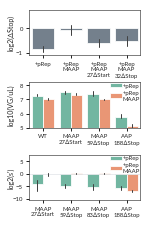

In [26]:
fig, ax =  plt.subplots(nrows=3, figsize = [2,3.5], gridspec_kw={'hspace':.6})

sns.barplot(x='level_2', y=0,order=['pRep','pEK_254', 'pEK_258','pEK_256' ], 
            data=maap_pos_only_diff_drop.stack().reset_index(),estimator=mapper,color='slategrey',errwidth=1, ax=ax[0])


ax[0].set_xticklabels(['+pRep','+pRep\nMAAP', u'+pRep\nMAAP\n27∆Start', u'+pRep\nMAAP\n32∆Stop'])
ax[0].set_ylabel(u'log2(∆Stop)')

ax[0].get_yaxis().set_ticks([0,-1])
ax[0].set_xlabel('')
ax[0].yaxis.set_label_coords(-.13, 0.5)


sns.barplot(x='Name', y='vector_genomes', hue='complement_plot',palette=sns.color_palette("Set2"), order = ["WT", "MAAP-27", "MAAP-59", "AAP-Stop"],
                data=individual_mut_validation_df.query(
                    "dnase==True").query('media=="cells"').query('dilution == 1e2'), ax=ax[1], errwidth=1)

ax[1].set_ylim((5,8.2))
ax[1].get_yaxis().set_ticks([5,6,7,8])
ax[1].set_ylabel('log10(VG/uL)')
ax[1].set_xlabel('')
ax[1].set_xticklabels(['WT',u'MAAP\n27∆Start\n', u'MAAP\n59∆Stop', u'AAP\n188∆Stop'])
ax[1].legend(frameon=False, loc='upper right', bbox_to_anchor=(1.04, 1.1),handletextpad=.1, labelspacing=.3)
ax[1].yaxis.set_label_coords(-.13, 0.5)

ax2=ax[0]
sns.barplot(x='Name', y='log2_diff', hue='complement_plot',palette=sns.color_palette("Set2"), 
                errwidth=1,
                data=competition_mut_validation_df, ax=ax[2])

ax[2].set_ylim([-10.5,7.5])
ax[2].get_yaxis().set_ticks([-10,-5,0,5])
# ax[2].set_yticks([0], minor=True)
ax[2].axhline(0, c='slategray',alpha=.3, lw=.5)
ax[2].get_yaxis().grid(which='minor')

ax[2].set_ylabel('log2(s\')')
ax[2].set_xlabel('')
ax[2].set_xticklabels([u'MAAP\n27∆Start\n', u'MAAP\n59∆Stop',  u'MAAP\n83∆Stop', u'AAP\n188∆Stop'])
ax[2].legend(frameon=False, loc='upper right', 
             bbox_to_anchor=(1.04, 1.1),handletextpad=.1, labelspacing=.3)

ax[2].yaxis.set_label_coords(-.13, 0.5)
ax[0].set_ylim((-1.1,.75))

# save_fig(fig,"a04_reviison_library_and_validation_complement.pdf" )

In [27]:
competition_mut_validation_df.groupby(['Name', 'complement'])['log2_diff'].describe()

for mutant in competition_mut_validation_df['Name'].unique():
        log2_diff_pRep = competition_mut_validation_df.\
            query("Name == @mutant").query("complement == 'pRep'")['log2_diff']
        log2_diff_pRep_maap = competition_mut_validation_df.\
            query("Name == @mutant").query("complement == 'pRep-MAAP'")['log2_diff']
        print (mutant)
        ttest = stats.ttest_ind(log2_diff_pRep, log2_diff_pRep_maap)
        print (ttest)


MAAP-27
Ttest_indResult(statistic=-2.5635654774380172, pvalue=0.062402090817060989)
MAAP-59
Ttest_indResult(statistic=-8.7808364554317624, pvalue=0.00092759772010057558)
MAAP-83
Ttest_indResult(statistic=-7.5520459357006979, pvalue=0.0016472496731745824)
AAP-Stop
Ttest_indResult(statistic=2.2234495062714035, pvalue=0.090265432439905355)


In [28]:
maap_pos_only_diff_drop_log2 = maap_pos_only_diff_drop.stack().apply(np.log2).reset_index()
maap_pos_only_diff_drop_log2.head()

,abs_pos,aa,level_2,0
0,32.0,I,pEK_254,0.826803
1,32.0,I,pRep,-1.138383
2,32.0,I,pEK_256,-0.437298
3,32.0,I,pEK_258,-0.269845
4,32.0,L,pEK_254,0.010889


In [29]:
maap_pos_only_diff_drop_log2.query("abs_pos==83")

,abs_pos,aa,level_2,0
384,83.0,I,pEK_254,-2.438840
385,83.0,I,pRep,-1.739827
386,83.0,I,pEK_256,-1.195089
387,83.0,I,pEK_258,-1.815114
388,83.0,L,pEK_254,-0.629659
389,83.0,L,pRep,-2.030504
390,83.0,L,pEK_256,-0.482842
391,83.0,L,pEK_258,-2.004990
392,83.0,V,pEK_254,-3.353296
393,83.0,V,pRep,-2.742255


In [30]:
# maap_aa_has_stop_subset_copy_tidy = maap_aa_has_stop_subset_copy.stack().to_frame().reset_index()
# maap_aa_has_stop_subset_copy_tidy['virus_stop'] = maap_aa_has_stop_subset_copy_tidy['stop_maap'] + '-' +maap_aa_has_stop_subset_copy_tidy['level_4']

# sns.barplot(x='level_4', y=0, hue='stop_gee')

In [31]:
maap_aa_has_stop_subset_copy.query('abs_pos > 34').head()

pEK_254      pRep   pEK_256   pEK_258
abs_pos aa codon stop_maap                                        
34.5    I  ATA   1          0.208965  0.214283  0.580158  0.107821
           ATC   0          0.233755  0.888912  0.449529  0.229407
           ATT   0          0.995115  1.111269  1.311293  2.059825
        L  CTA   1          0.777078  0.295767  0.505888  0.433526
           CTC   0          0.164557  1.208362  0.384893  0.749186

In [32]:
maap_aa_has_stop_subset_copy.query("abs_pos==59").query('stop_maap==1').apply(np.log2)

pEK_254      pRep   pEK_256   pEK_258
abs_pos aa codon stop_maap                                        
59.0    I  ATA   1         -0.234405 -0.874084 -2.828056 -1.381401
        L  CTA   1         -4.180255 -1.677970 -2.828643 -2.522071
           TTA   1         -8.035923 -3.163386 -3.741611 -6.423182
           CTA   1         -4.180255 -1.677970 -2.828643 -2.522071
           TTA   1         -8.035923 -3.163386 -3.741611 -6.423182
        V  GTA   1         -1.942133 -1.367793 -2.985219 -2.971056

In [33]:
maap_aa_has_stop_subset_copy['diff'] =  (maap_aa_has_stop_subset_copy['pEK_254']-maap_aa_has_stop_subset_copy['pRep'] ).apply(np.log2)

maap_aa_has_stop_subset_copy.sort_values('diff', ascending=False).query('stop_maap == 1').query('abs_pos>25').query('abs_pos < 130').head()

pEK_254      pRep   pEK_256   pEK_258      diff
abs_pos aa codon stop_maap                                                  
57.5    L  CTA   1          4.601085  0.367607  0.943494  0.077862  2.081844
                 1          4.601085  0.367607  0.943494  0.077862  2.081844
114.0   I  ATA   1          4.328798  0.311670  0.197473  0.152118  2.006165
84.0    V  GTA   1          2.781991  0.255932  0.434920  0.185430  1.336888
                 1          2.781991  0.255932  0.434920  0.185430  1.336888

In [34]:
maap_aa_has_stop_subset_pos_avg= maap_aa_has_stop_subset_copy.loc[np.arange(0,735)].groupby(level=['abs_pos', 'stop_maap']).mean()
maap_aa_has_stop_subset_pos_avg.head()

pEK_254      pRep   pEK_256   pEK_258      diff
abs_pos stop_maap                                                  
2.0     0          0.396265  0.567057  0.457693  0.436718 -3.188534
        1          0.265422  0.470362  0.323017  0.337040 -1.656654
3.0     0          0.913580  0.892131  1.024385  0.812959 -0.600963
        1          0.604664  0.513451  0.723164  0.728348 -1.745592
4.0     0          0.604094  0.770620  0.632347  0.634058 -3.751319

### shuffle codons within a position and amino acid 
This gives us the null distribution for non-stop vs stop-codon effect, which we can compare to for p-value computing

In [35]:
import time
st = time.time()
def shuffle_codons_in_aa_pos(df,num_iter,seed=100,load=False, 
                                 save_path='../data/dataframes/shuffled_codons_df.csv.gz'):
    if load:
        df = pd.read_csv(save_path, index_col=[0,1,2,3], header=[0,1,2,3,4])
        return df.sort_index(axis=1)
    np.random.seed(100)
    for iter_n in range(0, num_iter):
        maap_aa_has_stop_col_subset = df
        maap_aa_has_stop_col_subset_shuffled = maap_aa_has_stop_col_subset.groupby(level= 
            ['abs_pos', 'aa']).transform(np.random.permutation)
        new_cols =  [x + (str(iter_n),) for x in maap_aa_has_stop_col_subset_shuffled.columns ]
        maap_aa_has_stop_col_subset_shuffled.columns = pd.MultiIndex.from_tuples(new_cols)
        
        if iter_n ==0:
            merged_df = maap_aa_has_stop_col_subset_shuffled
        else:    
            merged_df = pd.concat([merged_df,maap_aa_has_stop_col_subset_shuffled ], axis=1)
        
    merged_df.columns.rename(
        ['name', 'comp', 'mut', 'rep', 'random_rep'],inplace=True)
    if save_path:
        merged_df.to_csv(save_path,compression='gzip')
    return merged_df.sort_index(axis=1)

num_iter = 100 # note: p-value from paper was calculated with num_iter = 5000
boostrap_df = shuffle_codons_in_aa_pos(maap_aa_has_stop_subset,num_iter = num_iter,load=True)
print ('time to run %.03f' % ((time.time()-st)/60.0))
boostrap_df.query("abs_pos == 32").head(6)


time to run 0.054


name                         pEK_254                                          \
comp                            True                                           
mut                               WT                                           
rep                                1                                           
random_rep                         0         1        10        11        12   
abs_pos aa codon stop_maap                                                     
32.0    I  ATA   1          0.633024  0.918425  0.918425  0.402550  0.402550   
           ATC   0          0.918425  0.633024  0.402550  0.633024  0.633024   
           ATT   0          0.402550  0.402550  0.633024  0.918425  0.918425   
        L  CTA   1          0.099931  0.942901  0.372068  0.455103  0.372068   
           CTC   0          0.464268  0.437772  0.942901  0.455103  0.372068   
           CTG   1          0.464268  0.942901  0.942901  0.372068  0.464268   

name                                                                          \
comp                                                                           
mut                                                                            
rep                                                                            
random_rep                        13        14        15        16        17   
abs_pos aa codon stop_maap                                                     
32.0    I  ATA   1          0.402550  0.918425  0.633024  0.918425  0.402550   
           ATC   0          0.633024  0.633024  0.918425  0.633024  0.918425   
           ATT   0          0.918425  0.402550  0.402550  0.402550  0.633024   
        L  CTA   1          0.437772  0.372068  0.099931  0.942901  0.372068   
           CTC   0          0.464268  0.455103  0.372068  0.464268  0.437772   
           CTG   1          0.437772  0.437772  0.942901  0.099931  0.464268   

name                          ...         pRep                                \
comp                          ...        False                                 
mut                           ...           WT                                 
rep                           ...            2                                 
random_rep                    ...           90        91        92        93   
abs_pos aa codon stop_maap    ...                                              
32.0    I  ATA   1            ...     0.908734  0.369961  0.908734  0.908734   
           ATC   0            ...     0.369961  0.720089  0.369961  0.369961   
           ATT   0            ...     0.720089  0.908734  0.720089  0.720089   
        L  CTA   1            ...     0.169076  0.622690  0.270394  0.581761   
           CTC   0            ...     1.010248  1.010248  0.369736  1.010248   
           CTG   1            ...     1.010248  0.581761  0.622690  0.581761   

name                                                                          \
comp                                                                           
mut                                                                            
rep                                                                            
random_rep                        94        95        96        97        98   
abs_pos aa codon stop_maap                                                     
32.0    I  ATA   1          0.720089  0.908734  0.720089  0.369961  0.908734   
           ATC   0          0.908734  0.720089  0.369961  0.720089  0.369961   
           ATT   0          0.369961  0.369961  0.908734  0.908734  0.720089   
        L  CTA   1          1.010248  0.270394  0.581761  0.581761  0.169076   
           CTC   0          0.622690  0.369736  0.270394  0.369736  1.010248   
           CTG   1          0.581761  0.622690  0.622690  0.581761  0.169076   

name                                  
comp                                  
mut                                   
rep                                   


In [36]:
boostrap_df_aa_mean = boostrap_df.groupby(level=['abs_pos','aa','stop_maap']).mean().apply(np.log10)

boostrap_df_aa_mean_diff = boostrap_df_aa_mean.unstack().groupby(
    level=['name', 'random_rep'], axis=1).diff(axis=1).xs(1, level='stop_maap', axis=1, drop_level=False)
boostrap_df_aa_mean_diff.query("abs_pos == 27")

name         pEK_254                                                    \
comp            True                                                     
mut               WT                                                     
rep                1                                                     
random_rep         0         1        10        11        12        13   
stop_maap          1         1         1         1         1         1   
abs_pos aa                                                               
27.0    I  -0.239806 -0.239806 -0.397048 -0.239806 -0.239806  0.494450   
        L  -0.034379  0.072823 -0.081982  0.155142 -0.172072  0.026233   
        V  -0.035062 -0.035062  0.297882 -0.534251 -0.534251  0.297882   

name                                                  ...         pRep  \
comp                                                  ...        False   
mut                                                   ...           WT   
rep                                                   ...            2   
random_rep        14        15        16        17    ...           90   
stop_maap          1         1         1         1    ...            1   
abs_pos aa                                            ...                
27.0    I   0.494450 -0.397048 -0.239806 -0.239806    ...    -0.164036   
        L   0.004411 -0.202057 -0.000757 -0.000757    ...    -0.022443   
        V  -0.534251  0.297882  0.297882  0.062197    ...    -0.120243   

name                                                                    \
comp                                                                     
mut                                                                      
rep                                                                      
random_rep        91        92        93        94        95        96   
stop_maap          1         1         1         1         1         1   
abs_pos aa                                                               
27.0    I  -0.164036 -0.164036 -0.047035 -0.047035  0.187548 -0.047035   
        L   0.012108  0.053926 -0.036435  0.013555 -0.022443 -0.006830   
        V  -0.120243  0.002166  0.002166 -0.026627 -0.026627  0.126884   

name                                      
comp                                      
mut                                       
rep                                       
random_rep        97        98        99  
stop_maap          1         1         1  
abs_pos aa                                
27.0    I  -0.164036 -0.047035 -0.164036  
        L   0.072092 -0.052442  0.028749  
        V  -0.120243 -0.120243 -0.026627  

[3 rows x 400 columns]

In [37]:
maap_stop_aa_mean = maap_aa_has_stop_subset.groupby(['abs_pos','aa', 'stop_maap']).mean().apply(
    np.log10)
maap_stop_aa_mean_diff = maap_stop_aa_mean.unstack().groupby(
        level=[0],axis=1).diff(axis=1).xs(1, level='stop_maap', axis=1, drop_level=False)
maap_stop_aa_mean_diff.query("abs_pos == 27").head()

pEK_254      pRep   pEK_256   pEK_258
                True     False     False     False
                  WT        WT   P32_ATA   P27_CCC
                   1         2         2         2
stop_maap          1         1         1         1
abs_pos aa                                        
27.0    I   0.494450  0.187548 -0.306027  0.152670
        L   0.294988  0.043783  0.187685 -0.378314
        V  -0.534251 -0.026627  0.373261 -0.325112

In [38]:
boostrap_df_aa_mean_diff.dropna(how='all').shape

(2681, 400)

In [39]:
boostrap_df_aa_mean_diff.loc[maap_stop_aa_mean_diff.index].shape

(3584, 400)

In [40]:
maap_stop_aa_mean_diff.dropna(how='all').shape

(2681, 4)

In [41]:
maap_stop_aa_mean_diff.shape

(3584, 4)

### using the distribuiton from shuffled codons, calculate z-scores and p-values

In [42]:
def compute_boostrap_pvalues(bootsrap_diff_df, gene_diff_df):
    bootsrap_diff_df = bootsrap_diff_df.loc[gene_diff_df.index]
    bootsrap_diff_df = bootsrap_diff_df.dropna(how='all')
    gene_diff_df = gene_diff_df.dropna(how='all')
    assert bootsrap_diff_df.shape[0] == gene_diff_df.shape[0]
    no_comp_df = bootsrap_diff_df.xs('pRep',level=0,axis=1,drop_level=False)
    no_comp = bootsrap_diff_df.xs('pRep',level=0,axis=1,drop_level=False).apply(
        lambda x: np.where(gene_diff_df.iloc[:,1].values.flatten()>x, 1,0)).sum(axis=1)
    df=pd.DataFrame()
    df_all_zscores_no_complement = pd.concat(
        [no_comp_df,gene_diff_df.iloc[:,1] ], axis=1).apply(stats.zscore, axis=1)
    df['zscore_nocomp'] = pd.DataFrame(df_all_zscores_no_complement.values.tolist(), index=no_comp_df.index ).iloc[:,-1]
    df['zscore_nocomp_pval'] = df['zscore_nocomp'].apply(special.ndtr)
#     df['zscore_nocomp'] = pd.concat(
#         [no_comp_df,gene_diff_df.iloc[:,1] ], axis=1).apply(stats.zscore, axis=1).iloc[:,-1].values
#     df['zscore_nocomp_pval'] = df['zscore_nocomp'].apply(special.ndtr)
    comp_df = bootsrap_diff_df.xs('pEK_254',level=0,axis=1,drop_level=False)
    comp = bootsrap_diff_df.xs('pEK_254',level=0,axis=1,drop_level=False).apply(
        lambda x: np.where(gene_diff_df.iloc[:,0].values.flatten()>x, 1,0)).sum(axis=1)
    df_all_zscores_complement = pd.concat(
        [comp_df,gene_diff_df.iloc[:,0] ], axis=1).apply(stats.zscore, axis=1)
    df['zscore_comp'] = pd.DataFrame(df_all_zscores_complement.values.tolist(), index=comp_df.index ).iloc[:,-1]
    df['zscore_comp_pval'] = df['zscore_comp'].apply(special.ndtr)
    maap_stat_df = pd.concat([no_comp,comp],axis=1)
#     return maap_stat_df
    maap_pvals = (((maap_stat_df +1) / (no_comp.max()+1)))
#     return df
#     return maap_pvals
    maap_pvals = pd.concat([maap_pvals,df],axis=1)
    return maap_pvals
maap_pvals = compute_boostrap_pvalues(boostrap_df_aa_mean_diff, maap_stop_aa_mean_diff)
maap_pvals.head()

0         1  zscore_nocomp  zscore_nocomp_pval  \
abs_pos aa                                                          
2.0     L   0.574257  0.821782       0.154797            0.561509   
        R   0.029703  0.009901      -1.771924            0.038204   
        S   0.009901  0.019802      -3.330701            0.000433   
        V   0.514851  0.702970       0.266669            0.605138   
2.5     I   0.009901  0.009901      -0.736811            0.230618   

            zscore_comp  zscore_comp_pval  
abs_pos aa                                 
2.0     L      1.053922          0.854041  
        R     -1.963908          0.024770  
        S     -2.887165          0.001944  
        V     -0.259780          0.397517  
2.5     I     -0.825238          0.204618

In [43]:
bootstrap_diff_pos_mean = boostrap_df_aa_mean_diff.groupby(level='abs_pos').mean()
maap_diff_pos_mean = maap_stop_aa_mean_diff.groupby(level='abs_pos').mean()

bootstrap_diff_pos_mean_r10 = bootstrap_diff_pos_mean.rolling(100, min_periods=0).mean()
maap_diff_pos_mean_r10 = maap_diff_pos_mean.rolling(100, min_periods=0).mean()

In [44]:
maap_pos_pvalues = compute_boostrap_pvalues(bootstrap_diff_pos_mean, maap_diff_pos_mean)
# maap_pos_pvalues.query('abs_pos==32')

In [45]:
bootstrap_diff_pos_mean_r10 = bootstrap_diff_pos_mean.rolling(30, min_periods=0).mean()
maap_diff_pos_mean_r10 = maap_diff_pos_mean.rolling(30, min_periods=0).mean()
maap_pos_pvalues_rolling = compute_boostrap_pvalues(
    bootstrap_diff_pos_mean_r10,maap_diff_pos_mean_r10)

### plot fitness as well as p-value at each position on the capsid

In [46]:
def plot_fitness_diff( maap_aa_has_stop_subset_pos_avg, column,ax=None, ):
    if not ax:
        fig,ax = plt.subplots(figsize=[8,.5])
    ax.scatter(list(maap_aa_has_stop_subset_pos_avg.query('stop_maap ==  1').reset_index()['abs_pos']),
             maap_aa_has_stop_subset_pos_avg.query('stop_maap ==  1')[column].apply(np.log2),s=.1, c='lightcoral' )
    ax.scatter(list(maap_aa_has_stop_subset_pos_avg.query('stop_maap ==  1').reset_index()['abs_pos']),
             maap_aa_has_stop_subset_pos_avg.query('stop_maap ==  0')[column].apply(np.log2),s=.1,c='slategrey' )

    ax.plot(list(maap_aa_has_stop_subset_pos_avg.query('stop_maap ==  1').reset_index()['abs_pos']),
             maap_aa_has_stop_subset_pos_avg.query(
                 'stop_maap ==  1')[column].rolling(10,min_periods=1).mean().apply(np.log2),c='lightcoral', lw=.5 )

    ax.plot(list(maap_aa_has_stop_subset_pos_avg.query('stop_maap ==  0').reset_index()['abs_pos']),
             maap_aa_has_stop_subset_pos_avg.query(
                 'stop_maap ==  0')[column].rolling(10,min_periods=1).mean().apply(np.log2),c='slategrey',lw=.5  )
    ax.set_xlim(0,735)
    ax.set_ylim(-3.5,.5)
    ax.set_xticks([])
    if not ax:
        return fig

In [47]:
def plot_pvalues(pval_df,smooth=None,
                 figname=None,
                 zscore=False,
                 figsize=[8,1.2], 
                 b_t_a = [.5,.9], complement=True, all_cond=False):
    fig=plt.figure(figsize=[20,5])
    if all_cond:
        fig, (a0,a1,a2,a3,a4,a5) = plt.subplots(6,1,figsize=figsize,sharex=True ,
            gridspec_kw = {'height_ratios':[.1, 1,1,1,1,1],"hspace":0.005})
        
    elif complement:
        fig, (a0,a1,a2,a3) = plt.subplots(4,1,figsize=figsize,sharex=True ,
            gridspec_kw = {'height_ratios':[.1, 1,1,1],"hspace":0.005})
    else: 
        fig, (a0,a1,a2) = plt.subplots(3,1,figsize=figsize,sharex=True ,
            gridspec_kw = {'height_ratios':[.1, 1,1],"hspace":0.005})
   
    a0.set_xlim(1,735)
    a0.set_ylim(-1,1)
    a0.plot([27,146],[0,0],linewidth=3,color='black', alpha=.65)
    a0.plot([176,380],[0,0],linewidth=3,color='grey', alpha=.65)
    a0.plot([576,732],[0,0],linewidth=3,color='grey', alpha=.65)
    plot_fitness_diff(maap_aa_has_stop_subset_pos_avg,'pRep',a1 )
    if complement:
        plot_fitness_diff(maap_aa_has_stop_subset_pos_avg,'pEK_254',a2 )
#     a1.set_ylabel()
    if all_cond:
        plot_fitness_diff(maap_aa_has_stop_subset_pos_avg,'pEK_256',a3 )
        plot_fitness_diff(maap_aa_has_stop_subset_pos_avg,'pEK_258',a4 )

    if zscore:
        comp_plot_var = 'zscore_comp_pval'
        no_comp_plot_var = 'zscore_nocomp_pval'
    else:
        comp_plot_var = 1
        no_comp_plot_var = 0
    if smooth:
        print ("smoothing")
        if complement:
            plt.plot(pval_df['abs_pos'], pval_df[no_comp_plot_var].apply(
                np.log10).rolling(smooth,min_periods=0).mean(),
                 label='Rep Only',linewidth=.5,c='black')
            plt.plot(pval_df['abs_pos'], pval_df[comp_plot_var].apply(
                np.log10).rolling(smooth,min_periods=0).mean(),
                 label='Rep + MAAP',linewidth=.5,c='blue', alpha=.5,linestyle='dashed')
        else:
            a2.plot(pval_df['abs_pos'], pval_df[no_comp_plot_var].apply(
                np.log10).rolling(smooth,min_periods=0).mean(),
                 label='Rep Only',linewidth=.5,c='black')
            
    else:
        print ("not smoothing")
        if all_cond:
            print( "all conditions")
            plt.plot(pval_df['abs_pos'], pval_df[no_comp_plot_var].apply(np.log10),
                 label='Rep Only',linewidth=.5,c='black')
            plt.plot(pval_df['abs_pos'], pval_df[comp_plot_var].apply(np.log10),
                 label='Rep + MAAP',linewidth=.5,c='blue', alpha=.5,linestyle='dashed')
            plt.plot(pval_df['abs_pos'], pval_df[comp_plot_var].apply(np.log10),
                 label='Rep + MAAP',linewidth=.5,c='blue', alpha=.5,linestyle='dashed')
            plt.ylim((-40,0))
        if complement:
            plt.plot(pval_df['abs_pos'], pval_df[no_comp_plot_var].apply(np.log10),
                     label='Rep Only',linewidth=.5,c='black')
            plt.plot(pval_df['abs_pos'], pval_df[comp_plot_var].apply(np.log10),
                     label='Rep + MAAP',linewidth=.5,c='blue', alpha=.5,linestyle='dashed')
            plt.ylim((-5,0))
        else:
            print ("no comp")
            a2.plot(pval_df['abs_pos'], pval_df[no_comp_plot_var].apply(np.log10),
                     label='Rep Only',linewidth=.5,c='black')
            a2.set_ylim((-40,0))

    plt.legend(bbox_to_anchor=b_t_a,frameon=False)
    a0.set_axis_off()
    plt.xlim(0,735)
#     plt.ylim(-4,0)
#     plt.yticks([0,-1,-2,-3])
    plt.xlabel('VP Position')
#     plt.ylabel('log10(p-val)')
    if figname:
        save_fig(fig, figname)

not smoothing
no comp


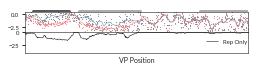

In [48]:
## note: to exactly reproduce figure in paper, you will need to run shuffle_codons_in_aa_pos() with num_iter=5000
## this will take >10 hours on standard machine and create 10gb file
plot_pvalues(maap_pos_pvalues_rolling.reset_index(),zscore=True,
             b_t_a=[1.02,.93],figsize=[4,(1.2*.66)],complement=False)